In [4]:
import os
import math
import random

import numpy as np
import seaborn as sns

from scipy.cluster.vq import vq
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.manifold import TSNE
from scipy import spatial
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

In [5]:
df = pd.read_csv("combined_df.csv", index_col=0)
df[["medianAlt", "medianSpeed", "medianResDist", "csm_1", "csm_2"]] = df[["medianAlt", "medianSpeed", "medianResDist", "csm_1", "csm_2"]].fillna(-1)
df["csm"] = df["csm_2"].apply(lambda v: -1 if v == -1 else 0 if v < 0.25 else 1)
df.describe()

,potential_bolide_id,potential_bolide_longitude,potential_bolide_latitude,confidence_x,confidence_y,_id,yaw_flip_flag,maxEnergy,totEnergy,nGroups,duration,latLonLinelets,energyRatio,splinelets,groundTrackDeviation,chop,glint,neighborhood,latLonLinearity,medianAlt_g16,medianSpeed_g16,medianResDist_g16,medianAlt_g17,medianSpeed_g17,medianResDist_g17,phase,moon_fullness,solarhour,sun_alt_obs,sun_alt_app,csm_1,csm_2,csm_1_17,csm_2_17,csm_2_16,csm_1_16,medianAlt,medianSpeed,medianResDist,csm
count,1.046200e+04,10462.000000,10462.000000,10462.000000,10462.000000,1.046200e+04,10462.000000,1.046200e+04,1.046200e+04,10462.000000,10462.000000,1.046200e+04,10462.000000,10462.000000,10462.000000,10462.000000,10462.000000,10462.000000,10462.000000,3211.000000,3155.000000,3211.000000,3211.000000,3155.000000,3211.000000,10462.000000,10462.000000,10462.000000,10462.000000,10462.000000,10462.000000,10462.000000,6244.000000,6499.000000,7219.000000,6906.000000,10462.000000,10462.000000,10462.000000,10462.000000
mean,1.670407e+18,-87.148347,3.601100,0.625546,0.625546,1.670407e+18,0.591092,6.264099e+00,5.888253e+02,80.812369,0.231162,4.891630e+00,0.527657,0.002362,0.852568,0.012114,5511.177680,2.082681,0.742186,58.080970,65.286836,5.532964,58.080471,67.558957,5.532964,0.488264,0.499358,9.286280,7.392259,7.328547,0.377022,0.369244,0.736064,0.722009,0.671229,0.685639,17.133071,19.332560,1.005099,0.550946
std,5.000122e+16,73.344535,25.120392,0.306245,0.306245,5.000122e+16,0.912619,6.407166e+02,6.022736e+04,178.726562,0.456445,4.778883e+02,0.180490,0.003501,33.950905,0.018633,3152.547260,91.983063,0.260694,32.557276,231.374621,32.207530,32.557939,237.012072,32.207530,0.288409,0.287409,5.756323,41.233293,41.237418,0.724817,0.706302,0.295533,0.269117,0.287680,0.318352,32.677854,117.118216,18.093840,0.792877
min,1.620192e+18,-179.999374,-56.537132,0.200069,0.200069,1.620192e+18,0.000000,1.285030e-15,2.218620e-14,20.000000,0.022126,2.555835e-14,0.000000,0.000000,0.000432,0.000000,4.593179,0.000000,0.005218,9.167527,0.056485,0.006051,9.173078,0.000000,0.006051,0.000019,0.000003,0.001867,-88.451701,-88.451701,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,1.620210e+18,-128.302391,-15.850136,0.298573,0.298573,1.620210e+18,0.000000,5.584514e-15,1.407766e-13,26.000000,0.069428,7.570421e-11,0.438458,0.000539,0.005727,0.000000,3392.679474,0.000000,0.548289,15.775042,0.624227,1.594395,15.774445,0.672190,1.594395,0.237668,0.244627,5.020162,-25.131102,-25.131102,0.148147,0.225339,0.544748,0.542497,0.463430,0.453355,-1.000000,-1.000000,-1.000000,0.000000
50%,1.720192e+18,-99.512493,5.634765,0.663504,0.663504,1.720192e+18,0.000000,1.098387e-14,3.033284e-13,39.000000,0.123216,2.382963e-10,0.534224,0.001320,0.008247,0.000000,5170.720946,0.000000,0.801423,77.382745,8.145276,3.172864,77.382513,20.754300,3.172864,0.481271,0.495826,8.177124,9.671023,9.581787,0.673771,0.647313,0.862540,0.804092,0.738883,0.795939,-1.000000,-1.000000,-1.000000,1.000000
75%,1.720203e+18,-63.486264,22.711296,0.952000,0.952000,1.720203e+18,2.000000,2.508217e-14,7.789268e-13,72.000000,0.236515,7.406727e-10,0.630079,0.002945,0.015766,0.020833,7258.230318,0.000000,0.997102,85.285183,78.737991,5.836398,85.282451,81.868300,5.836398,0.738424,0.749574,12.438772,40.697847,40.679415,0.949403,0.891535,0.992240,0.960099,0.931756,0.978489,15.083587,0.562104,1.190934,1.000000
max,1.720222e+18,179.988892,56.449947,1.000000,1.000000,1.720222e+18,2.000000,6.553500e+04,6.160290e+06,6799.000000,14.052796,4.886167e+04,1.000000,0.077194,3308.090866,0.243902,20015.086796,9260.136364,1.000000,108.444170,7758.017464,1572.705731,108.441648,8979.397522,1572.705731,0.999999,0.999913,23.998081,89.502041,89.501931,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,108.442909,6501.974879,1572.705731,1.000000


In [6]:
target_columns = ['yaw_flip_flag', 'maxEnergy', 'totEnergy',
       'nGroups', 'duration', 'latLonLinelets', 'energyRatio', 'splinelets',
       'groundTrackDeviation', 'chop', 'glint', 'neighborhood',
       'latLonLinearity', 'medianAlt', 'medianSpeed',
       'medianResDist', 'phase', 'moon_fullness', 'solarhour',
       'sun_alt_obs', 'sun_alt_app', 'csm']

X = df[target_columns]
y = df["is_bolide"].astype(int)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=0)

X_test_index = X_test.index
X_val_index = X_val.index

# use standard scaler to rescale by running fit and transform on hand coded train features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
# apply the same transform to val and test
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# NOTE: replace clf below with XGBoost or whatever other model
# creating a RF classifier
clf = RandomForestClassifier(n_estimators = 100, random_state=42) 

# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [7]:
test_df = pd.DataFrame(X_test)
test_df["confidence"] = df.loc[X_test_index, "confidence_x"].values
test_df["y"] = y_test.values
test_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,confidence,y
0,-0.648327,-0.000205,-0.072119,-0.331598,-0.423126,-0.011978,-1.922996,0.145130,-0.047067,-0.652218,-1.192068,-0.022732,-0.239213,-0.561747,-0.158934,-0.099906,1.468637,-1.098811,-0.562015,-0.138573,-0.145390,0.563881,0.322000,0
1,1.542431,-0.142941,-0.074036,-0.154515,-0.282517,-0.011978,0.523250,-0.230729,-0.047487,1.356974,-0.265094,-0.022732,0.982272,-0.561747,-0.158934,-0.099906,-1.140001,-0.646131,0.192952,0.721037,0.722007,0.563881,0.974753,1
2,-0.648327,-0.163745,-0.076457,-0.126846,0.088108,-0.011978,-1.919015,0.912457,-0.044794,-0.652218,-1.705859,-0.022732,0.042317,-0.561747,-0.158934,-0.099906,1.355983,-0.874379,0.528288,1.854112,1.855447,0.563881,0.240000,0
3,-0.648327,-0.060304,-0.073593,-0.320530,0.138449,-0.011978,0.331036,1.165824,-0.047547,-0.652218,4.625800,-0.022732,0.375806,-0.131810,0.088056,0.019764,-0.890997,-0.150059,1.981302,-0.867246,-0.865618,0.563881,0.212000,0
4,-0.648327,-0.183392,-0.079419,-0.281793,-0.385804,-0.011978,0.209491,-0.280858,-0.047655,-0.652218,0.542557,-0.022732,-1.111139,2.308321,-0.138008,-0.018013,-0.192683,1.241140,-1.104009,-0.993206,-0.991567,0.563881,0.990000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1042,-0.648327,-0.036611,-0.073888,-0.337132,-0.210474,-0.011978,1.567516,-0.034536,-0.047708,-0.652218,2.165329,-0.022732,-0.092391,-0.139518,-0.051621,0.534699,0.428780,0.972818,1.931119,-1.198334,-1.196676,0.563881,0.676000,0
1043,-0.648327,-0.090354,-0.071398,-0.176650,-0.286856,-0.011978,0.793004,-0.347638,-0.034219,0.434386,-0.624060,-0.022732,0.402792,-0.561747,-0.158934,-0.099906,-0.459433,0.709712,-0.239149,0.668712,0.669644,0.563881,0.668000,1
1044,-0.648327,-0.121559,-0.073962,-0.220921,-0.340669,-0.011978,-0.309979,-0.536153,-0.047850,1.945031,-0.230781,-0.022732,-0.301182,-0.561747,-0.158934,-0.099906,0.551197,0.728936,-0.947485,-0.702746,-0.701133,0.563881,0.934000,1
1045,1.542431,-0.136006,-0.065148,-0.010635,0.689607,-0.011978,-1.807847,-0.379196,-0.036671,-0.652218,0.086809,-0.000698,0.988878,-0.017020,-0.158934,0.011067,-0.371590,0.884717,1.056708,0.628363,0.629263,-1.971732,0.210757,0


In [8]:
cs = np.arange(0.2, 1.05, 0.05)
ps = []
rs = []
for c in cs:
  current_df = test_df.loc[test_df.confidence >= c]
  current_y = current_df["y"].values
  current_pred = clf.predict(current_df.drop(["confidence", "y"], axis=1))
  cr = classification_report(current_y, current_pred, output_dict=True)
  wa = cr["weighted avg"]
  p = wa["precision"]
  r = wa["recall"]
  ps.append(p)
  rs.append(r)

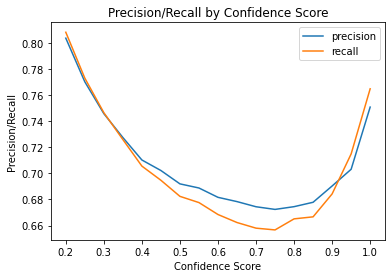

In [9]:
plt.title("Precision/Recall by Confidence Score")
plt.plot(cs, ps, label="precision")
plt.plot(cs, rs, label="recall")
plt.xlabel("Confidence Score")
plt.ylabel("Precision/Recall")
_ = plt.legend()

Reference Plot Without CSM

In [10]:
# plt.title("Precision/Recall by Confidence Score")
# plt.plot(cs, ps, label="precision")
# plt.plot(cs, rs, label="recall")
# plt.xlabel("Confidence Score")
# plt.ylabel("Precision/Recall")
# _ = plt.legend()

## Gradient Boost, Default Perams

In [11]:
import pandas as pd
import numpy as np 
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [14]:
#Importing libraries
import os
import math

import numpy as np
import matplotlib.pyplot as plt
## import cv2
import pandas as pd
import random
import seaborn as sns
from scipy.cluster.vq import vq
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.manifold import TSNE
from scipy import spatial
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [12]:
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb = GradientBoostingClassifier(learning_rate=learning_rate)
    gb.fit(X_train, y_train)
    predictions = gb.predict(X_val)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(X_val, y_val)))

Learning rate:  0.05
Accuracy score (training): 0.809
Accuracy score (validation): 0.801
Learning rate:  0.075
Accuracy score (training): 0.822
Accuracy score (validation): 0.810
Learning rate:  0.1
Accuracy score (training): 0.833
Accuracy score (validation): 0.809
Learning rate:  0.25
Accuracy score (training): 0.863
Accuracy score (validation): 0.809
Learning rate:  0.5
Accuracy score (training): 0.906
Accuracy score (validation): 0.802
Learning rate:  0.75
Accuracy score (training): 0.921
Accuracy score (validation): 0.801
Learning rate:  1
Accuracy score (training): 0.930
Accuracy score (validation): 0.781


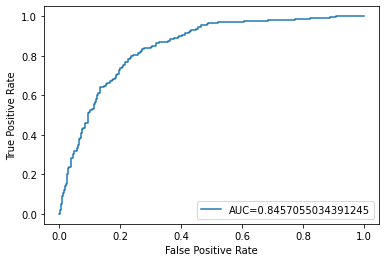

In [15]:
#define metrics
y_pred_proba = gb.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

## Gradient Boost, estimators = 100, max features = 2, max_depth = 2

In [16]:
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=learning_rate, max_features=2, max_depth=2, random_state=None)
    gb_clf.fit(X_train, y_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_val, y_val)))

Learning rate:  0.05
Accuracy score (training): 0.769
Accuracy score (validation): 0.771
Learning rate:  0.075
Accuracy score (training): 0.789
Accuracy score (validation): 0.785
Learning rate:  0.1
Accuracy score (training): 0.795
Accuracy score (validation): 0.789
Learning rate:  0.25
Accuracy score (training): 0.822
Accuracy score (validation): 0.807
Learning rate:  0.5
Accuracy score (training): 0.835
Accuracy score (validation): 0.807
Learning rate:  0.75
Accuracy score (training): 0.844
Accuracy score (validation): 0.801
Learning rate:  1
Accuracy score (training): 0.851
Accuracy score (validation): 0.796


Classification Report
              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1261
           1       0.72      0.62      0.67       622

    accuracy                           0.80      1883
   macro avg       0.77      0.75      0.76      1883
weighted avg       0.79      0.80      0.79      1883

Confusion Matrix:


<AxesSubplot:>

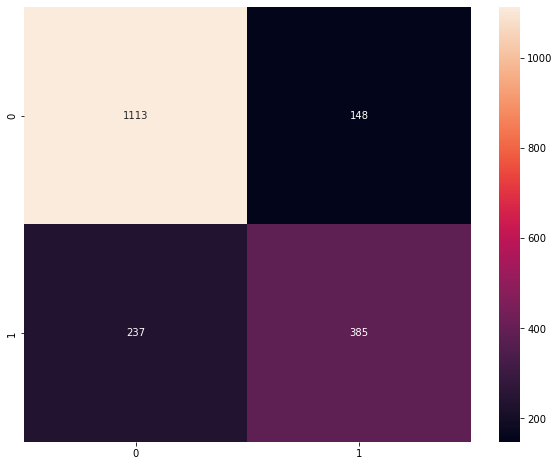

In [17]:
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_features=2, max_depth=2, random_state=None)
gb_clf.fit(X_train, y_train)
predictions = gb_clf.predict(X_val)

print("Classification Report")
print(classification_report(y_val, predictions))

print("Confusion Matrix:")
con = confusion_matrix(y_val, predictions)
plt.figure(figsize=(10,8))
sns.heatmap(con, annot=True, fmt='d')

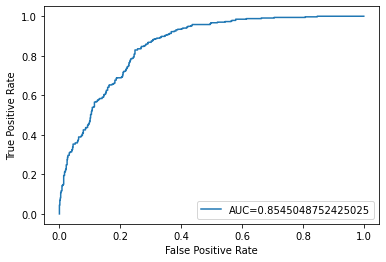

In [18]:
#define metrics
y_pred_proba = gb_clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

## Gradient Boost, estimators = 100, max features = None, max_depth = 3

In [19]:
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_clf2 = GradientBoostingClassifier(n_estimators=100, learning_rate=learning_rate, max_features=None, max_depth=3, random_state=None)
    gb_clf2.fit(X_train, y_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf2.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf2.score(X_val, y_val)))

Learning rate:  0.05
Accuracy score (training): 0.809
Accuracy score (validation): 0.801
Learning rate:  0.075
Accuracy score (training): 0.822
Accuracy score (validation): 0.810
Learning rate:  0.1
Accuracy score (training): 0.833
Accuracy score (validation): 0.809
Learning rate:  0.25
Accuracy score (training): 0.863
Accuracy score (validation): 0.809
Learning rate:  0.5
Accuracy score (training): 0.906
Accuracy score (validation): 0.803
Learning rate:  0.75
Accuracy score (training): 0.921
Accuracy score (validation): 0.801
Learning rate:  1
Accuracy score (training): 0.930
Accuracy score (validation): 0.782


Classification Report
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1261
           1       0.73      0.66      0.70       622

    accuracy                           0.81      1883
   macro avg       0.79      0.77      0.78      1883
weighted avg       0.81      0.81      0.81      1883

Confusion Matrix:


<AxesSubplot:>

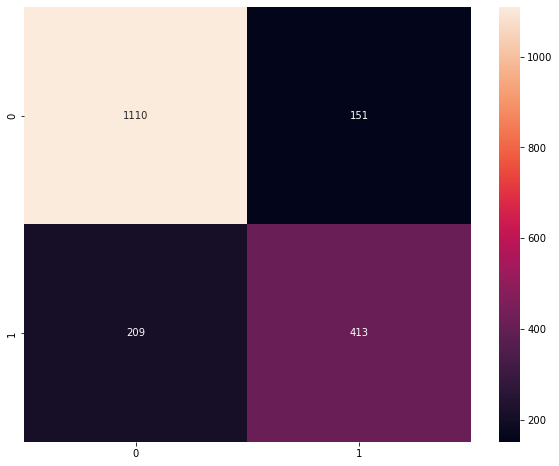

In [20]:
gb_clf2 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_features=None, max_depth=3, random_state=None)
gb_clf2.fit(X_train, y_train)
predictions = gb_clf2.predict(X_val)

print("Classification Report")
print(classification_report(y_val, predictions))

print("Confusion Matrix:")
con = confusion_matrix(y_val, predictions)
plt.figure(figsize=(10,8))
sns.heatmap(con, annot=True, fmt='d')

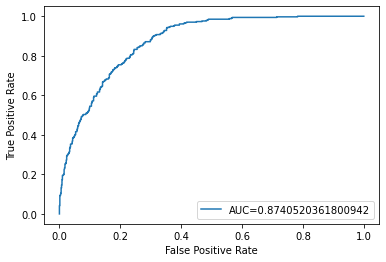

In [21]:
#define metrics
y_pred_proba = gb_clf2.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

## XGBoost

In [22]:
xgb_clf = XGBClassifier(learning_rate=.075)
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.075, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [23]:
score = xgb_clf.score(X_val, y_val)
print(score)

0.8114710568242167


In [24]:
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    xgb = XGBClassifier(learning_rate=learning_rate)
    xgb.fit(X_train, y_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(xgb.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(xgb.score(X_val, y_val)))

Learning rate:  0.05
Accuracy score (training): 0.875
Accuracy score (validation): 0.813
Learning rate:  0.075
Accuracy score (training): 0.893
Accuracy score (validation): 0.811
Learning rate:  0.1
Accuracy score (training): 0.913
Accuracy score (validation): 0.818
Learning rate:  0.25
Accuracy score (training): 0.972
Accuracy score (validation): 0.808
Learning rate:  0.5
Accuracy score (training): 0.999
Accuracy score (validation): 0.802
Learning rate:  0.75
Accuracy score (training): 1.000
Accuracy score (validation): 0.792
Learning rate:  1
Accuracy score (training): 1.000
Accuracy score (validation): 0.788


Classification Report
              precision    recall  f1-score   support

           0       0.86      0.87      0.87      1261
           1       0.73      0.71      0.72       622

    accuracy                           0.82      1883
   macro avg       0.79      0.79      0.79      1883
weighted avg       0.82      0.82      0.82      1883

Confusion Matrix:


<AxesSubplot:>

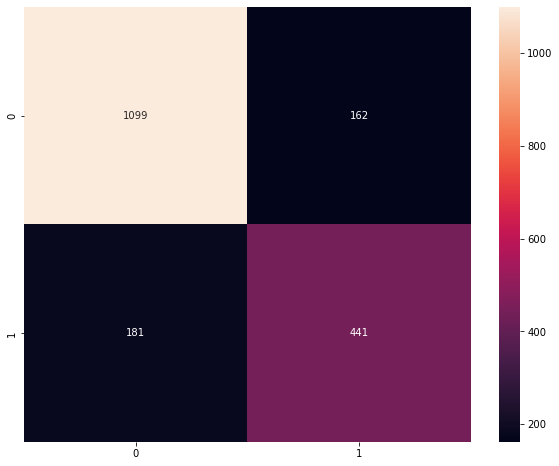

In [25]:
xgb = XGBClassifier(learning_rate=0.1)
xgb.fit(X_train, y_train)
predictions = xgb.predict(X_val)

print("Classification Report")
print(classification_report(y_val, predictions))

print("Confusion Matrix:")
con = confusion_matrix(y_val, predictions)
plt.figure(figsize=(10,8))
sns.heatmap(con, annot=True, fmt='d')

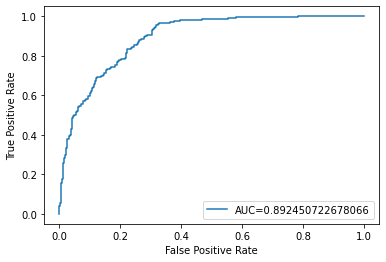

In [26]:
#define metrics
y_pred_proba = xgb.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()